# Data Wrangling

In [1]:
import matplotlib.pyplot as plt
import nltk
import pymongo
import pandas as pd
import re

from pymongo import MongoClient
from nltk.corpus import stopwords
from wordcloud import WordCloud

### Processo ETL
O processo de extração dos Tweets foi feito pelo script `tweets_extracts.py` que pode ser encontrado no mesmo repo deste notebook, o processo de Data Wragling agora é simplesmente uma busca pelo Tweets do idioma pt.

In [2]:
client = pymongo.MongoClient("mongodb+srv://dbUser:<PWD>@cluster0.vbnow.mongodb.net/hackathon_santander?retryWrites=true&w=majority")
db = client.hackathon_santander

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/whrocha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

###  Filtros
- Somente tweets marcados como pt pelo Twitter.
- Retirado do texto a palavra RT para nao atrapalhar na visualizaçao do word cloud

In [4]:
def filter_entries(entries, stopwords):

    text_entries = entries
    regex_str = '[^a-zA-Z\u00C0-\u00FF 0-9]+'
    subbed_entries = re.sub(regex_str, ' ', text_entries)
    split_entries = subbed_entries.split()

    stop_words = stopwords

    entries_words = []

    for word in split_entries:
        if word not in stop_words:
            entries_words.append(word)

    return entries_words

In [5]:
words = []

stop_words = set(stopwords.words('portuguese'))

myquery = { 
    "lang": "pt",
}

for tweet in db.tweet_stream_db.find(myquery):
    
    try:
        text_tweet = tweet['extended_tweet']['full_text']
    except:
        text_tweet = tweet['text']
    
    entries = filter_entries(text_tweet.replace('RT', ''), stop_words)
    
    words.append(entries)
    
string_words = ' '.join([str(w1) for w in words for w1 in w])

# Modelagem / Estudos

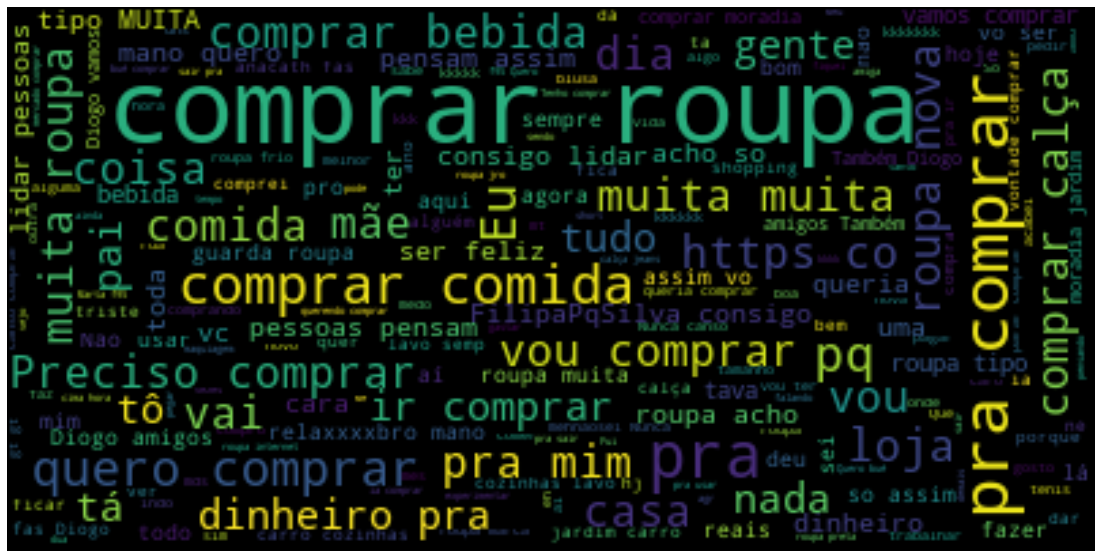

In [6]:
# Generate a word cloud image
wordcloud = WordCloud().generate(string_words)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt

# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")

# lower max_font_size
# wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Validação dos resultados

In [7]:
api_key_ibm = {
    "apikey": "",
    "iam_apikey_description": "",
    "iam_apikey_name": "",
    "iam_role_crn": "",
    "iam_serviceid_crn": "",
    "url": ""
}

In [8]:
import json

from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 import Features, SentimentOptions


### Análise de sentimento
Analise de sentimento para direcionar os lead dos tweets feitos que contém os termos `COMPRAR` `ROUPA`

In [9]:
def return_tweet_sentiment(tweet_text):
    
    authenticator = IAMAuthenticator(api_key_ibm['apikey'])

    natural_language_understanding = NaturalLanguageUnderstandingV1(
        version='2019-07-12',
        authenticator=authenticator
    )

    natural_language_understanding.set_service_url(api_key_ibm['url'])

    response = natural_language_understanding.analyze(
        text=tweet_text,
        features=Features(
            sentiment=SentimentOptions()
        )
    ).get_result()

    return response
    

In [11]:
# pesquisar somente os tweets que possuem COMPRAR ROUPA
myquery = { 
    "lang": "pt"
}

substring1 = "comprar" 
substring2 = "roupa"

tweets_sentimental_analysis = []

print('Start sentimental analysis')

for tweet in db.tweet_stream_db.find(myquery):
    
    try:
        text_tweet = tweet['extended_tweet']['full_text']
    except:
        text_tweet = tweet['text']
        
    # pesquisar se a tweet contem as palavras comprar e roupas
    if substring1 in text_tweet.lower() and substring2 in text_tweet.lower():
        
        try:
            
            sentiment = return_tweet_sentiment(text_tweet)

            item = {
                'id': tweet['id'],
                'text_tweet': text_tweet,
                'sentiment_score': sentiment['sentiment']['document']['score'],
                'sentiment_label': sentiment['sentiment']['document']['label'],
                'sentiment_language': sentiment['language']
            }

            tweets_sentimental_analysis.append(item)
            
        except Exception as e:

            pass
        
print('Done') 

Start sentimental analysis


ERROR:root:unsupported text language: gl
Traceback (most recent call last):
  File "/home/whrocha/Repositories/d4p-hackathon-santander-datachallenge/venv/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: unsupported text language: gl, Code: 400 , X-global-transaction-id: 2bf3a5ea6775a1f9f5f64eeccb9e591c


Done


In [12]:
## adicionar usuario a analise
myquery = { 
    "lang": "pt"
}

for tweet in db.tweet_stream_db.find(myquery):
    
    list_tt = [tt for tt in tweets_sentimental_analysis if tt['id'] == tweet['id']]
    
    for tt in list_tt:
        
        user_data = tweet.get('user', '')
        
        tt['user_profile'] = ''
        
        if user_data != '':
            
            tt['user_profile'] = user_data.get('screen_name', '')

### Utilizando somente os tweets marcados como positivos para a geraçao dos leads

In [13]:
df = pd.DataFrame(tweets_sentimental_analysis)

In [14]:
df.head()

,id,text_tweet,sentiment_score,sentiment_label,sentiment_language,user_profile
0,1289664201221271553,RT @jcorreia_2003: Preciso de comprar urgentem...,-0.931266,negative,pt,Lara95841276
1,1289664348651020289,"Quero comprar roupa e calçadoooo, alguém me se...",-0.799481,negative,pt,_alinekonzgen
2,1289664516515442688,Comprar roupa e ter que trocar a roupa\n\nquar...,-0.660715,negative,pt,Juu_Isaa
3,1289664584417021952,@Seforamarquess @Buzeli2 @Maryssferrazz Eu não...,-0.985481,negative,pt,1problhama
4,1289664753019826177,"Tive que comprar uma roupa sem experimentar, a...",0.946554,positive,pt,nnicolly_eu


### Existe uma possível conversão de 23%

In [15]:
df.sentiment_label.value_counts()

negative    1157
positive     345
neutral       43
Name: sentiment_label, dtype: int64

### Utilizar somente tweet com sentimento igual ou maior que 80% de confiança

In [16]:
df_final = df[(df.sentiment_label == 'positive') & (df.sentiment_score >= 0.8)]

In [17]:
df_final.head()

,id,text_tweet,sentiment_score,sentiment_label,sentiment_language,user_profile
4,1289664753019826177,"Tive que comprar uma roupa sem experimentar, a...",0.946554,positive,pt,nnicolly_eu
18,1289666262042279937,Fui pela primeira vez comprar roupa à secção d...,0.854070,positive,pt,dianalasallete
50,1289670070080122881,gnt esse look e da loja da mnh amiga tati ela ...,0.995421,positive,pt,natrr21
58,1289670795128532992,@Dalberini Odiei comprar roupa online e adorei...,0.921806,positive,pt,jsantosoli
62,1289671435124977664,a indecisão de comprar um guarda roupa rosa pq...,0.870029,positive,pt,mduda_medina


In [18]:
df_final.user_profile.value_counts()

                   17
ChelseaRafael3      1
_costalucas         1
AwrgCatra           1
_juuuu16            1
                   ..
Carolzinha10_10     1
nathaliadmatos_     1
ghoshinoo           1
aarilinda           1
garelaa1            1
Name: user_profile, Length: 102, dtype: int64

### Salvar a lista como csv

In [19]:
df_final.to_csv('customer_leads_score.csv')